# Basic Exploration

This first section is just me playing around with the API. A demo of the basic request and response extraction, playing with some type conversion, and made a few charts.

After 2 charts, a clear pattern emerged. 

In [43]:
import pandas as pd
import numpy as np
from openai import OpenAI

client = OpenAI()

numbers_response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
    {
        "role": "system", # Without this GPT added friendly but awkward to parse text to the output.
        "content": "You are a number generator. In all of your responses only use numbers, with each number separated using a space."
    },
    {
        "role": "user",
        "content": "Generate 1000 random numbers."
    }],
    temperature=1,
    max_tokens=4096, # Artificially large, GPT should generate many fewer if it follows the prompt.
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
)
numbers_text = numbers_response.choices[0].message.content
print('--------- response -----------')
print(numbers_text)




--------- response -----------
0 7 10 23 31 44 56 67 72 85 98 105 114 122 135 142 155 167 175 183 196 203 219 222 234 247 253 262 274 289 297 305 310 328 334 341 359 366 373 389 393 407 416 424 430 445 454 461 476 482 497 503 519 522 534 541 558 566 571 589 594 608 615 627 634 647 654 663 678 681 695 701 715 722 739 748 753 769 775 787 799 804 819 820 835 841 854 868 872 888 893 902 919 927 935 949 954 960 973 980 997 999 1006 1019 1027 1044 1056 1068 1081 1089 1103 1112 1120 1137 1148 1157 1173 1176 1189 1204 1208 1219 1231 1242 1255 1257 1272 1284 1296 1310 1319 1331 1337 1344 1358 1367 1374 1378 1395 1403 1418 1423 1434 144...


Funny little note: GPT left an ellipsis at the end of the response as if to say "I didn't really want to generate 1000, so just pretend it goes on like this.

In [44]:

# Assume GPT followed instructions split on space should give some numbers
chat_gpt_random_list = numbers_text.split(' ')
print(f'Length: {len(chat_gpt_random_list)}\n')

# Check for anything that doesn't appear to be a number
# lets make lists with all the failures separately
non_floats = []
non_ints = []
floats = []
ints = []

for i in chat_gpt_random_list:
    try:
        floats.append(float(i))
    except:
        print("non-float value: ", i)
        non_floats.append(i)

    try:
        ints.append(int(i))
    except:
        print('non-int value: ', i)
        non_ints.append(i)

print(f'''
Ints      : {len(ints)}
Floats    : {len(floats)}
Non-ints  : {len(non_ints)}
Non-floats: {len(non_floats)}
''')

print(f'Int Range  : {min(ints)} - {max(ints)}')
print(f'Float Range: {min(ints)} - {max(ints)}')

# Lets see if every number in the range is represented for ints
for i in range(min(ints), max(ints)):
    if i not in ints:
        print(f"{i} is not represented in the range {min(ints)} - {max(ints)}")


Length: 144

non-float value:  144...
non-int value:  144...

Ints      : 143
Floats    : 143
Non-ints  : 1
Non-floats: 1

Int Range  : 0 - 1434
Float Range: 0 - 1434
1 is not represented in the range 0 - 1434
2 is not represented in the range 0 - 1434
3 is not represented in the range 0 - 1434
4 is not represented in the range 0 - 1434
5 is not represented in the range 0 - 1434
6 is not represented in the range 0 - 1434
8 is not represented in the range 0 - 1434
9 is not represented in the range 0 - 1434
11 is not represented in the range 0 - 1434
12 is not represented in the range 0 - 1434
13 is not represented in the range 0 - 1434
14 is not represented in the range 0 - 1434
15 is not represented in the range 0 - 1434
16 is not represented in the range 0 - 1434
17 is not represented in the range 0 - 1434
18 is not represented in the range 0 - 1434
19 is not represented in the range 0 - 1434
20 is not represented in the range 0 - 1434
21 is not represented in the range 0 - 1434
22 is

# Random Notes

* The only failing value was the string `'144...'` 
    * I bet it will fail similarly with some other punctuation marks or other error.
    * Which means any program relying on this behavior needs to sanitize the input -- that might be a pain.
    * In this case maybe use a regex to remove everything but digits and space characters?
        * But can you ever really trust it?

* In general it makes me think people using the outputs of GPT as input to other programs or to generate other code, programs, or CLI commands that might be run without much skepticism seems like a great attack vector for the new era of LLMs. 
    * Try to get the model to train on malicious data,
    * Try to engineer a safe-seeming prompt that results in a risky output,
    * I'm sure some enterprising folks are doing this.

In [45]:
# Lets make a histogram of the numbers and compare it with a "uniform distribution"
# Using ints since that's what GPT seems to produce.
chat_gpt_random_series = pd.Series(ints)

# ChatGPT doesn't always give us the number of numbers we asked for.
# and since we don't specify a min/max we set bounds dynamically
np_random = pd.Series(
    np.random.randint(
        chat_gpt_random_series.min(),
        1 + chat_gpt_random_series.max(), # WEIRD, because the upper bound is "exclusive" in np's API
        size=len(chat_gpt_random_series)
    )
)

df = pd.DataFrame(dtype='int32', data={
    'GPT': chat_gpt_random_series,
    'NumPy': np_random
})

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   GPT     143 non-null    int32
 1   NumPy   143 non-null    int32
dtypes: int32(2)
memory usage: 1.2 KB


,GPT,NumPy
count,143.00000,143.000000
mean,708.65035,681.748252
std,419.74899,408.597437
min,0.00000,19.000000
25%,350.00000,310.000000
50%,701.00000,631.000000
75%,1062.00000,1015.500000
max,1434.00000,1427.000000


# Random Thoughts

* 143 is a weird number of numbers to have generated when I asked for 1000.
* Is it a coincidene that 143 generated, and 1434 is the largest generated value?

array([[<Axes: title={'center': 'GPT'}>,
        <Axes: title={'center': 'NumPy'}>]], dtype=object)

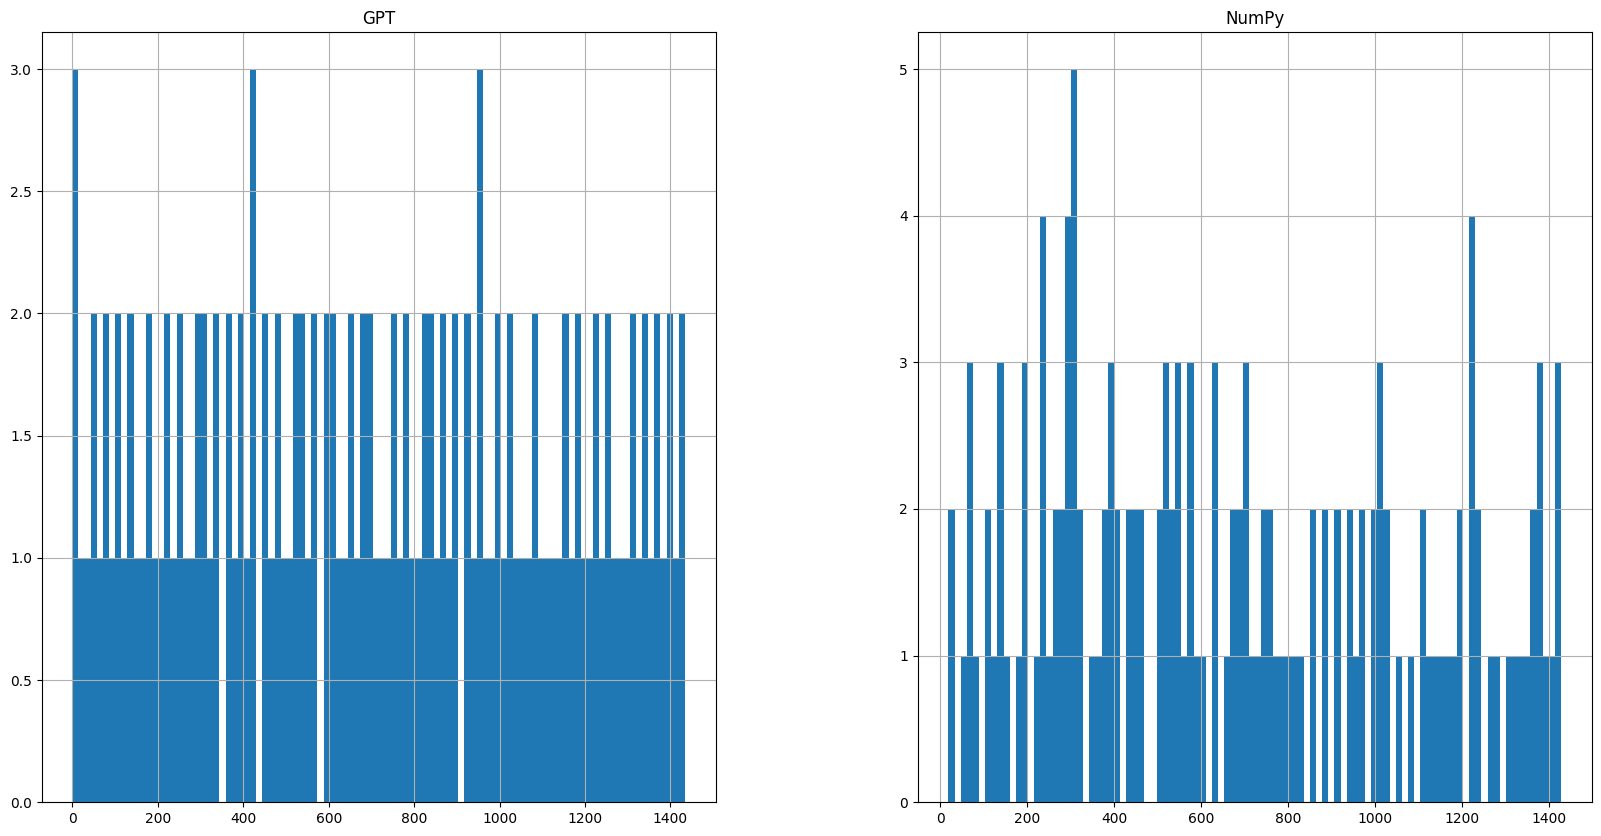

In [46]:
df.hist(bins=100, figsize=(20,10))

## I'm Surprised the Distribution is so Uniform!!

`np.random.randint` draws from a uniform distribution. That makes me wonder if the numbers are being produced more systematically. Lets visualize the numbers in the order they were produced and see if anything sticks out.

<Axes: >

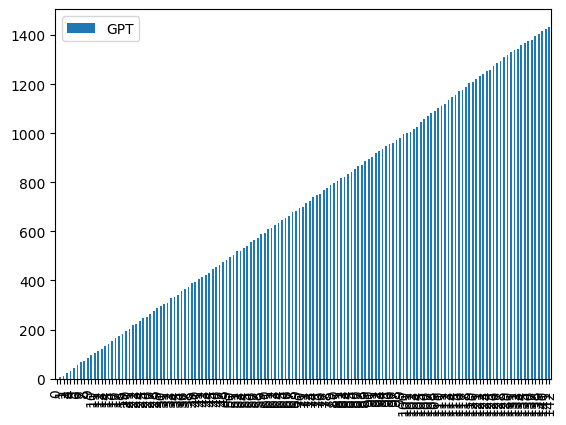

In [50]:
df.plot.bar(y='GPT') 

# Well would you look at that...

You don't always find an obvious pattern so fast. Lucky me!

## Areas for inquiry

* Is this sample representative of GPT's emulation of randomness?
    * Will it usually be sorted? Will other systematic patterns be used as well?
    * Will the number of numbers always be wrong, and is there a pattern there?
        * If I ask for some specific number of numbers will it be consistently right? 
        * Maybe smaller numbers would work better since they are more likely to have a single token?
        * Is there something systematic about how the numbers are off?
    * It doesn't do "random" well but if I ask for other specific patterns will it respond properly?